In [ ]:
#default_exp data

In [ ]:
#export
from timeseries_fastai.imports import *
from timeseries_fastai.core import *
from fastai2.basics import *
from fastai2.torch_core import *
from fastai2.vision.data import get_grid

# Data
> putting together timeseries...

In [ ]:
#export
def TSBlock(cls=TSeries): return TransformBlock(type_tfms=cls.create)

In [ ]:
dblock = DataBlock(blocks=(TSBlock, CategoryBlock),
                   get_x=get_x,
                   get_y=get_y,
                   splitter=RandomSplitter(0.2))

In [ ]:
ucr_path = untar_data(URLs.UCR)

In [ ]:
df_train, df_test = load_df_ucr(ucr_path, 'Adiac')

Loading files from: /home/tc256760/.fastai/data/Univariate2018_arff/Adiac


In [ ]:
dls = dblock.dataloaders(df_train, bs=4)

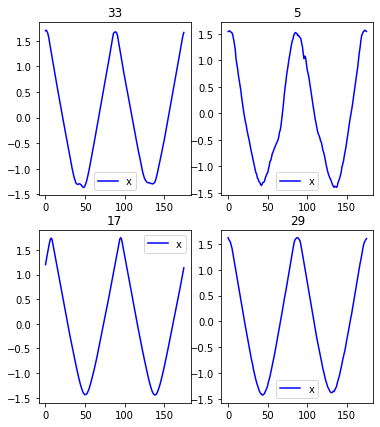

In [ ]:
dls.show_batch()

In [ ]:
#export
class TSDataLoaders(DataLoaders):
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_df(cls, df, path='.', valid_pct=0.2, seed=None, x_cols=None, label_col=None,
                y_block=None, valid_col=None, item_tfms=None, batch_tfms=None, **kwargs):
        y_block = ifnone(y_block, CategoryBlock)
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)
        dblock = DataBlock(blocks=(TSBlock, y_block),
                           get_x=ColReader(x_cols),
                           get_y=ColReader(label_col),
                           splitter=splitter,
                           item_tfms=item_tfms, 
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, df, path=path, **kwargs)

Add grid spacing for show_batch

In [ ]:
#export
@typedispatch
def show_batch(x: TSeries, y, samples, ctxs=None, max_n=10,rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), rows=rows, cols=cols, add_vert=1, figsize=figsize)
    ctxs = show_batch[object](x, y, samples=samples, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

merge Dataframes

In [ ]:
df_train.assign(valid=False)

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att169,att170,att171,att172,att173,att174,att175,att176,target,valid
0,1.598007,1.599439,1.570529,1.550474,1.507371,1.434341,1.368986,1.305294,1.210305,1.116653,...,1.217175,1.312530,1.402920,1.481043,1.521012,1.564154,1.570855,1.592890,b'22',False
1,1.701146,1.670645,1.618884,1.546805,1.475469,1.391209,1.305882,1.237313,1.153414,1.069690,...,1.097360,1.182578,1.266291,1.350571,1.435160,1.519737,1.602518,1.670190,b'28',False
2,1.722342,1.695329,1.656946,1.606312,1.511824,1.414148,1.313688,1.213234,1.112978,1.015081,...,1.164750,1.263924,1.364303,1.463511,1.547307,1.641809,1.694973,1.708488,b'21',False
3,1.726263,1.659836,1.573108,1.496264,1.409070,1.332443,1.245742,1.158882,1.073361,0.987165,...,1.199608,1.275380,1.362258,1.448567,1.535131,1.622158,1.707838,1.739027,b'15',False
4,1.778976,1.761203,1.703084,1.610572,1.492088,1.368654,1.244761,1.120900,1.010762,0.900168,...,1.285657,1.408878,1.507983,1.623643,1.713606,1.766389,1.783633,1.758625,b'2',False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,1.670599,1.655859,1.610092,1.525893,1.440673,1.356233,1.271895,1.187667,1.102549,1.019581,...,1.138088,1.222857,1.307347,1.391835,1.461304,1.545888,1.629884,1.670952,b'31',False
386,1.691787,1.662870,1.618478,1.542548,1.453737,1.363733,1.272630,1.183061,1.093747,1.005159,...,1.168986,1.257817,1.350585,1.440217,1.528335,1.604386,1.656697,1.682137,b'33',False
387,2.595598,2.625063,2.423959,2.245083,2.332734,2.081564,1.853862,1.649852,1.469948,1.326733,...,1.389820,1.586436,1.815561,1.852951,1.845519,2.144000,2.128894,2.117635,b'6',False
388,1.659900,1.644147,1.593779,1.536218,1.456986,1.371655,1.287932,1.201311,1.113499,1.028015,...,1.169743,1.256185,1.343048,1.428322,1.512527,1.579867,1.636902,1.660197,b'28',False


In [ ]:
x_cols = df_train.columns[slice(0,-1)].to_list()

In [ ]:
#export
def stack_train_valid(df_train, df_valid):
    return pd.concat([df_train.assign(valid_col=False), df_valid.assign(valid_col=True)]).reset_index(drop=True)

In [ ]:
df = stack_train_valid(df_train, df_test)

In [ ]:
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att169,att170,att171,att172,att173,att174,att175,att176,target,valid_col
0,1.598007,1.599439,1.570529,1.550474,1.507371,1.434341,1.368986,1.305294,1.210305,1.116653,...,1.217175,1.312530,1.402920,1.481043,1.521012,1.564154,1.570855,1.592890,b'22',False
1,1.701146,1.670645,1.618884,1.546805,1.475469,1.391209,1.305882,1.237313,1.153414,1.069690,...,1.097360,1.182578,1.266291,1.350571,1.435160,1.519737,1.602518,1.670190,b'28',False
2,1.722342,1.695329,1.656946,1.606312,1.511824,1.414148,1.313688,1.213234,1.112978,1.015081,...,1.164750,1.263924,1.364303,1.463511,1.547307,1.641809,1.694973,1.708488,b'21',False
3,1.726263,1.659836,1.573108,1.496264,1.409070,1.332443,1.245742,1.158882,1.073361,0.987165,...,1.199608,1.275380,1.362258,1.448567,1.535131,1.622158,1.707838,1.739027,b'15',False
4,1.778976,1.761203,1.703084,1.610572,1.492088,1.368654,1.244761,1.120900,1.010762,0.900168,...,1.285657,1.408878,1.507983,1.623643,1.713606,1.766389,1.783633,1.758625,b'2',False


In [ ]:
dls = TSDataLoaders.from_df(df, x_cols=x_cols, label_col='target', valid_col='valid_col')

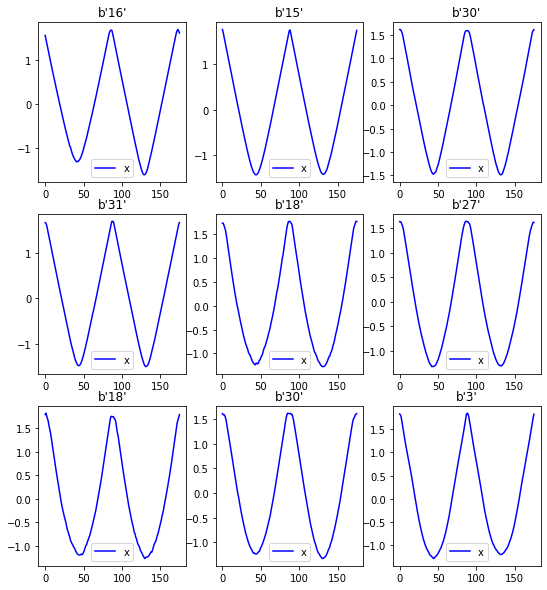

In [ ]:
dls.show_batch()

# Export -

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.ipynb.
Converted 02_models.ipynb.
Converted 99_index.ipynb.
